In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers


pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('dark_background')

In [2]:
train = pd.read_csv('./files/train_cleaned.csv')
test = pd.read_csv('./files/test_cleaned.csv')

train.shape, test.shape

((1456, 144), (1459, 143))

<p>Using pd get dummies to handle missing categorical features</p>

In [3]:
d = pd.DataFrame({'a': ['ba', 'ca', np.nan], 'c': ["da", 'aa', 'cd']})
pd.get_dummies(d)

a_ba  a_ca  c_aa  c_cd  c_da
0     1     0     0     0     1
1     0     1     1     0     0
2     0     0     0     1     0

<p>but since we do not have any missing values we do not need to do this</p>

In [4]:
num_feats = train.drop('SalePrice', axis=1).corr().columns # before getting dummies 
cat_feats = train.select_dtypes(include=['object']).columns # before getting dummies

In [5]:
pd.get_dummies(train, drop_first=True).shape, pd.get_dummies(test, drop_first=True).shape

((1456, 295), (1459, 281))

<p>There is a problem the number of columns in train and test dataset is not matching. There are different ways to handle these situation. The way to handle this situation can be done in different ways. I found the solution in Sir <b>Vaibhav Shukla</b> artile <a href='https://medium.com/@vaibhavshukla182/how-to-solve-mismatch-in-train-and-test-set-after-categorical-encoding-8320ed03552f'>How to solve mismatch in train and test set after categorical encoding?</a>

<p>There are mainly three ways to handle these situations. But here we will add the train and test set and then do one hot encoding</p>

In [6]:
train['train'] = 1
test['train'] = 0

In [7]:
combined = pd.concat([train, test]) # concating the rows 

combined = pd.get_dummies(combined, drop_first=True)

In [8]:
train = combined[combined['train'] == 1].drop(columns=['train'])
test = combined[combined['train'] == 0].drop(columns=['train', 'SalePrice']) # saleprice are given as null values

train.shape, test.shape

((1456, 296), (1459, 295))

In [9]:
x = train.drop('SalePrice', axis=1)
y = train['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)

In [10]:
x_train.shape, x_test.shape

((1164, 295), (292, 295))

In [11]:
scaler_features = StandardScaler()
scaler_target = StandardScaler()

x_train[num_feats] = scaler_features.fit_transform(x_train[num_feats])
x_test[num_feats] = scaler_features.transform(x_test[num_feats])
test[num_feats] = scaler_features.transform(test[num_feats])

# we would not transform the target values as they are already log transformed and LB scored is measure with log values

In [12]:
from sklearn.model_selection import KFold

k = KFold(10)
for x_tr, z_tr in k.split(x_train):
    print(x_tr.shape, z_tr.shape)

(1047,) (117,)
(1047,) (117,)
(1047,) (117,)
(1047,) (117,)
(1048,) (116,)
(1048,) (116,)
(1048,) (116,)
(1048,) (116,)
(1048,) (116,)
(1048,) (116,)


In [13]:
scorer = make_scorer(mean_squared_error)

def mse_train_score(model):
    return np.sqrt(cross_val_score(model, x_train, y_train, scoring=scorer, cv=10))

def mse_test_score(model):
    return np.sqrt(cross_val_score(model, x_test, y_test, scoring=scorer, cv=10))

RMSE in training set: 4862673044.452188
RMSE in test set: 15.387798563284907


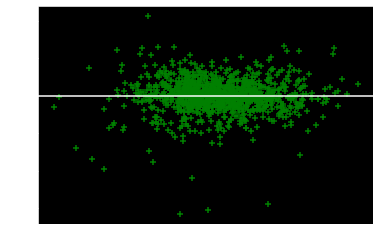

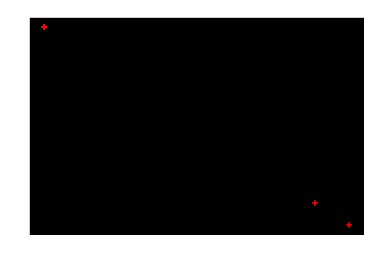

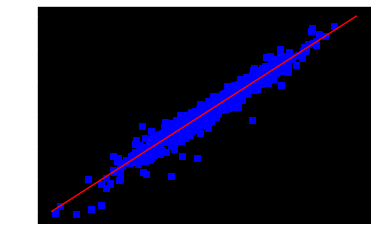

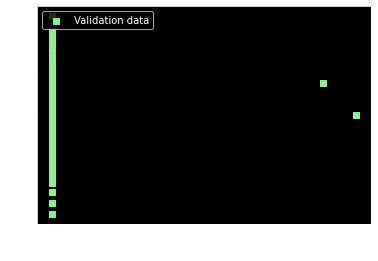

In [14]:
lr = LinearRegression()
lr.fit(x_train, y_train)

print('RMSE in training set: {}'.format(mse_train_score(lr).mean()))
print('RMSE in test set: {}'.format(mse_test_score(lr).mean()))

# plotting residuals
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

plt.scatter(y_train_pred, y_train-y_train_pred, color='green', marker='+')
plt.axhline()

plt.figure()
plt.scatter(y_test_pred, y_test-y_test_pred, color='red', marker="+")

plt.show()


# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.figure()

plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.legend(loc = "upper left")

plt.show()

<p>We can see that the model is performing very very very bad and it is moslty due to multicolinearity. To tackle this problem we will use L1 regulizer(lasso) which discards unncessary or multicolinear features by assinging weight zero to features, L2 regulizers(Ridge) which does not discards features but makes the weights close to zero, ELASTICNET(mixture of both l1 and l2)discards unnessary features and make the taken features weight very small</p>

<h3># L2 regulizer </h3>

In [15]:
# here since we are using x_train and x_test so does do make sense to cross split the again by using hyper parameter cv
# we would have use cv value if use had used the whole trained dataset and did not split the data using train test split
ridge = RidgeCV(alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                       0.8, 1, 10, 20, 30, 50, 60])# using ridge cv to try out multiple alphas(lambda value) at the same time

ridge.fit(x_train, y_train)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.8,  1. , 10. , 20. , 30. ,
       50. , 60. ]))

In [16]:
alpha = ridge.alpha_

print(f"Best alpha : {alpha}")

Best alpha : 20.0


In [17]:
print("Try again for more precision with alphas centered around " + str(alpha))

ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4])

ridge.fit(x_train, y_train)

# new alpha center around the previous one
alpha = ridge.alpha_
print(f"Best new alpha : {alpha}")

# rmse score

print('RMSE in training set: {}'.format(mse_train_score(ridge).mean()))
   
print('RMSE in test set: {}'.format(mse_train_score(ridge).mean()))
      
print("MEAN squared error {} ".format(np.sqrt(mean_squared_error(y_test, ridge.predict(x_test)))))

Try again for more precision with alphas centered around 20.0
Best new alpha : 19.0
RMSE in training set: 0.11466018500091268
RMSE in test set: 0.11466018500091268
MEAN squared error 0.10550022694702221 


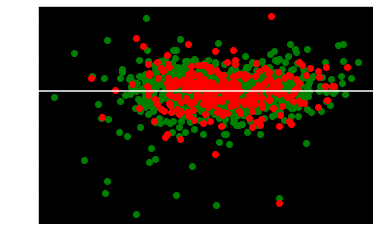

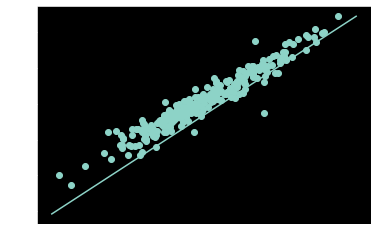

In [18]:
# plotting residuals
y_train_pred = ridge.predict(x_train)
y_test_pred = ridge.predict(x_test)

plt.scatter(y_train_pred, y_train-y_train_pred, color='green')
plt.scatter(y_test_pred, y_test-y_test_pred, color='red')
plt.axhline()

# plotting regression line
plt.show()
plt.scatter(y_test_pred, y_test)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_train), np.max(y_test)])
plt.show()

L1 regulizers picked 293 and discarded 2 features


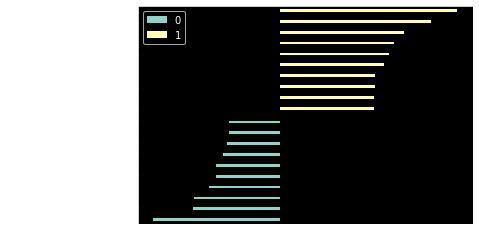

In [19]:
coef = pd.Series(ridge.coef_, index=x_train.columns)
print(f"L1 regulizers picked {sum(coef != 0)} and discarded {sum(coef == 0)} features")

imp_coefs = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)], axis=1)
imp_coefs.plot(kind='barh')
plt.show()

<h3># L1 Regulizer</h3>

In [20]:
lasso = LassoCV(alphas=[0.001, 0.0015, 0.003, 0.004, 0.005, 0.006, 0.009, 0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5], 
                max_iter=50000)
lasso.fit(x_train, y_train)

print("MEAN squared error {} ".format(mean_squared_error(y_test, ridge.predict(x_test))))

MEAN squared error 0.011130297885873192 


In [21]:
alpha = lasso.alpha_

print(f"Best alpha : {alpha}")

Best alpha : 0.001


In [22]:
print("Try again for more precision with alphas centered around " + str(alpha))

lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], max_iter=5000)

lasso.fit(x_train, y_train)


# new alpha center around the previous one
alpha = lasso.alpha_
print(f"Best new alpha : {alpha}")

# rmse score

print('RMSE in training set: {}'.format(mse_train_score(lasso).mean()))
   
print('RMSE in test set: {}'.format(mse_train_score(lasso).mean()))
      
print("MEAN squared error {} ".format(np.sqrt(mean_squared_error(y_test, lasso.predict(x_test)))))

Try again for more precision with alphas centered around 0.001
Best new alpha : 0.0006
RMSE in training set: 0.11334082227704786
RMSE in test set: 0.11334082227704786
MEAN squared error 0.10391729380026506 


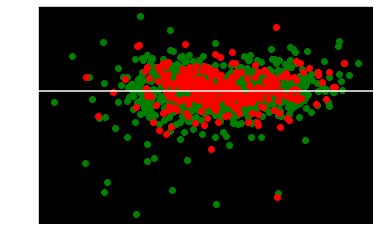

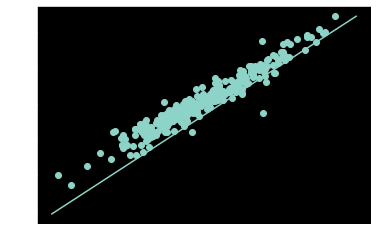

In [23]:
# plotting residuals
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

plt.scatter(y_train_pred, y_train-y_train_pred, color='green')
plt.scatter(y_test_pred, y_test-y_test_pred, color='red')
plt.axhline()

# plotting regression line
plt.show()
plt.scatter(y_test_pred, y_test)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_train), np.max(y_test)])
plt.show()

L1 regulizers picked 101 and discarded 194 features


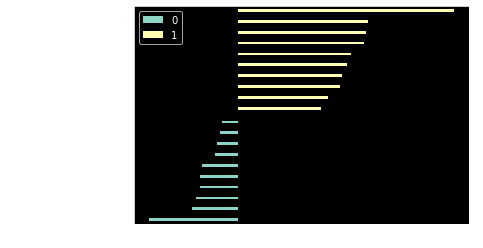

In [24]:
coef = pd.Series(lasso.coef_, index=x_train.columns)
print(f"L1 regulizers picked {sum(coef != 0)} and discarded {sum(coef == 0)} features")

imp_coefs = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)], axis=1)
imp_coefs.plot(kind='barh')
plt.show()

<p>There is a another model which is very good for situation like this. That is ElasticNetCV. It has both l1 and l2 penalty. So it not only removes all the useless feature but also reduce the important features weights to zero</p>

In [25]:
elasticnet = ElasticNetCV(l1_ratio=[0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         alphas=[0.03, 0.01, 0.05, 0.08, 0.1, 0.2, 0.5, 0.7, 0.8, 1, 3, 5, 10, 
                                 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006], 
                        max_iter = 50000)

elasticnet.fit(x_train, y_train)

ElasticNetCV(alphas=[0.03, 0.01, 0.05, 0.08, 0.1, 0.2, 0.5, 0.7, 0.8, 1, 3, 5,
                     10, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006],
             l1_ratio=[0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1], max_iter=50000)

In [26]:
alpha = elasticnet.alpha_
ratio = elasticnet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.2
Best alpha : 0.003


In [27]:
print("Try again for more precision with l1_ratio centered around " + str(ratio))

elasticnet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000)
elasticnet.fit(x_train, y_train)

Try again for more precision with l1_ratio centered around 0.2


ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                     0.06, 0.1, 0.3, 0.6, 1, 3, 6],
             l1_ratio=[0.17, 0.18000000000000002, 0.19, 0.2,
                       0.21000000000000002, 0.22000000000000003,
                       0.22999999999999998],
             max_iter=50000)

In [28]:
if (elasticnet.l1_ratio_ > 1):
    elasticnet.l1_ratio_ = 1   
    
alpha = elasticnet.alpha_
ratio = elasticnet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.18000000000000002
Best alpha : 0.003


In [29]:
print("now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticnet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000)

elasticnet.fit(x_train, y_train)

if (elasticnet.l1_ratio_ > 1):
    elasticnet.l1_ratio_ = 1    
alpha = elasticnet.alpha_
ratio = elasticnet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

now try again for more precision on alpha, with l1_ratio fixed at 0.18000000000000002 and alpha centered around 0.003
Best l1_ratio : 0.18000000000000002
Best alpha : 0.003


RMSE in training set: 0.11355862426620891
RMSE in test set: 0.11355862426620891
MEAN squared error 0.10404571501468798 


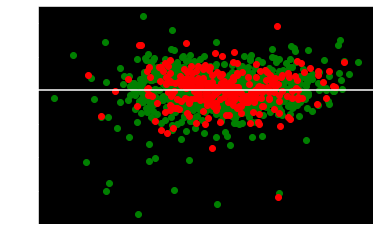

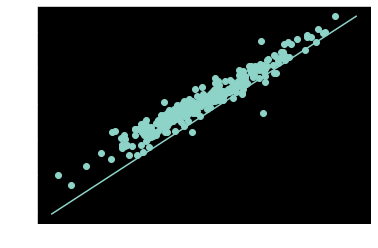

In [30]:
# rmse score

print('RMSE in training set: {}'.format(mse_train_score(elasticnet).mean()))
   
print('RMSE in test set: {}'.format(mse_train_score(elasticnet).mean()))
      
print("MEAN squared error {} ".format(np.sqrt(mean_squared_error(y_test, elasticnet.predict(x_test)))))

# plotting residuals
y_train_pred = elasticnet.predict(x_train)
y_test_pred = elasticnet.predict(x_test)

plt.scatter(y_train_pred, y_train-y_train_pred, color='green')
plt.scatter(y_test_pred, y_test-y_test_pred, color='red')
plt.axhline()

# plotting regression line
plt.show()
plt.scatter(y_test_pred, y_test)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_train), np.max(y_test)])
plt.show()

L1 regulizers picked 112 and discarded 183 features


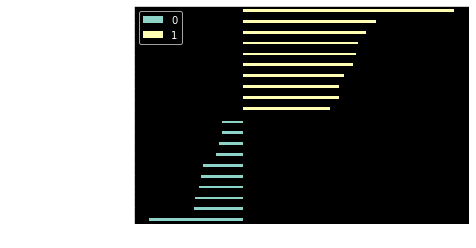

In [31]:
coef = pd.Series(elasticnet.coef_, index=x_train.columns)
print(f"L1 regulizers picked {sum(coef != 0)} and discarded {sum(coef == 0)} features")

imp_coefs = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)], axis=1)
imp_coefs.plot(kind='barh')
plt.show()

<p>Not only elastic net reduced the number of features the weights are also very low</p>

<p>Using XGBoost to predict prices</p>

<h1>Learn more about xgboost </h1>

In [32]:
import xgboost as xgb

F:\anaconda-env\tensor\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [33]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

params = {'max_depth': 2, "eta": 0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

F:\anaconda-env\tensor\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<AxesSubplot:>

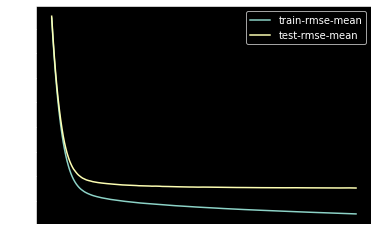

In [34]:
model.loc[30:, ['train-rmse-mean', 'test-rmse-mean']].plot()

In [35]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(x_train, y_train)

F:\anaconda-env\tensor\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=360, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
xgb_predict = model_xgb.predict(x_test)
np.sqrt(mean_squared_error(y_test, xgb_predict))

0.11359619135798127

<p>Using keras and tensorflow to predict values</p>

In [37]:
model_tf = keras.Sequential([
    keras.layers.Dense(100, input_shape=(x_train.shape[1],), activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

model_tf.compile(
    optimizer='adam',
    loss = 'mean_squared_error'
)

model_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               29600     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 31,841
Trainable params: 31,841
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_tf.fit(x_train, y_train, epochs=100)

Epoch 1/100
37/37 [==============================] - 1s 2ms/step - loss: 63.2455
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 3.6795
Epoch 3/100
37/37 [==============================] - 0s 1ms/step - loss: 0.7560
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.4910
Epoch 5/100
37/37 [==============================] - 0s 1ms/step - loss: 0.3794
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.2974
Epoch 7/100
37/37 [==============================] - 0s 1ms/step - loss: 0.2425
Epoch 8/100
37/37 [==============================] - 0s 1ms/step - loss: 0.2046
Epoch 9/100
37/37 [==============================] - 0s 1ms/step - loss: 0.1795
Epoch 10/100
37/37 [==============================] - 0s 1ms/step - loss: 0.1509
Epoch 11/100
37/37 [==============================] - 0s 1ms/step - loss: 0.1313
Epoch 12/100
37/37 [==============================] - 0s 1ms/step - loss: 0.1167
Epoch 13/100
37/37 [================

In [39]:
print(model_tf.evaluate(x_test))

10/10 [==============================] - 0s 1ms/step - loss: 0.0000e+00
0.0


In [40]:
np.sqrt(mean_squared_error(y_train, model_tf.predict(x_train)))

0.09125452208305083

In [41]:
np.sqrt(mean_squared_error(y_test, model_tf.predict(x_test)))

0.4039702513089567

<p>The noraml neural network clearly getting overfit. So we can handle this problem with these solution below</p>

<h3>Neural networks with regulizers and dropout</h3>

In [42]:
# with dropout
model_tf_drop = keras.Sequential([
    keras.layers.Dense(100, input_shape=(x_train.shape[1],), activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

model_tf_drop.compile(
    optimizer='adam',
    loss = 'mean_squared_error'
)

model_tf_drop.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               29600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 31,841
Trainable params: 31,841
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_tf_drop.fit(x_train, y_train, epochs=100)

Epoch 1/100
37/37 [==============================] - 1s 1ms/step - loss: 75.9091
Epoch 2/100
37/37 [==============================] - 0s 1ms/step - loss: 5.0237
Epoch 3/100
37/37 [==============================] - 0s 1ms/step - loss: 1.5173
Epoch 4/100
37/37 [==============================] - 0s 1ms/step - loss: 1.0782
Epoch 5/100
37/37 [==============================] - 0s 1ms/step - loss: 0.9601
Epoch 6/100
37/37 [==============================] - 0s 1ms/step - loss: 0.8774
Epoch 7/100
37/37 [==============================] - 0s 1ms/step - loss: 0.8214
Epoch 8/100
37/37 [==============================] - 0s 1ms/step - loss: 0.7547
Epoch 9/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6601
Epoch 10/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6867
Epoch 11/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6572
Epoch 12/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6684
Epoch 13/100
37/37 [================

In [44]:
np.sqrt(mean_squared_error(y_train, model_tf_drop.predict(x_train)))

0.3021871223770796

In [45]:
np.sqrt(mean_squared_error(y_test, model_tf_drop.predict(x_test)))

0.40043017139413956

<p>We can say that dropout is not performing very bad. Lets try regulizers</p>

In [46]:
# l2 regularizer
model_tf_reg2 = keras.Sequential([
    keras.layers.Dense(100, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer='l2'),
    keras.layers.Dense(20, activation='relu', kernel_regularizer='l2'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

model_tf_reg2.compile(
    optimizer='adam',
    loss = 'mean_squared_error'
)

model_tf_reg2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               29600     
_________________________________________________________________
dense_9 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 31,841
Trainable params: 31,841
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_tf_reg2.fit(x_train, y_train, epochs=120)

Epoch 1/120
37/37 [==============================] - 1s 1ms/step - loss: 44.6613
Epoch 2/120
37/37 [==============================] - 0s 1ms/step - loss: 4.3479
Epoch 3/120
37/37 [==============================] - 0s 1ms/step - loss: 2.4434
Epoch 4/120
37/37 [==============================] - 0s 1ms/step - loss: 2.0606
Epoch 5/120
37/37 [==============================] - 0s 1ms/step - loss: 1.8650
Epoch 6/120
37/37 [==============================] - 0s 1ms/step - loss: 1.7367
Epoch 7/120
37/37 [==============================] - 0s 1ms/step - loss: 1.6518
Epoch 8/120
37/37 [==============================] - 0s 1ms/step - loss: 1.5599
Epoch 9/120
37/37 [==============================] - 0s 1ms/step - loss: 1.4929
Epoch 10/120
37/37 [==============================] - 0s 1ms/step - loss: 1.4274
Epoch 11/120
37/37 [==============================] - 0s 1ms/step - loss: 1.3762
Epoch 12/120
37/37 [==============================] - 0s 1ms/step - loss: 1.3229
Epoch 13/120
37/37 [================

37/37 [==============================] - 0s 1ms/step - loss: 0.1951
Epoch 103/120
37/37 [==============================] - 0s 1ms/step - loss: 0.2844
Epoch 104/120
37/37 [==============================] - 0s 1ms/step - loss: 0.2407
Epoch 105/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1978
Epoch 106/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1764
Epoch 107/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1695
Epoch 108/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1521
Epoch 109/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1591
Epoch 110/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1571
Epoch 111/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1454
Epoch 112/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1359
Epoch 113/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1345
Epoch 114/120
37/37 [=========

In [48]:
np.sqrt(mean_squared_error(y_train, model_tf_reg2.predict(x_train)))

0.20349997753334484

In [49]:
np.sqrt(mean_squared_error(y_test, model_tf_reg2.predict(x_test)))

0.2760859559014037

<p>L2 regulization is not performing very good either</p>

In [50]:
# l1 regularizer
model_tf_reg1 = keras.Sequential([
    keras.layers.Dense(200, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer='l1'),
    keras.layers.Dense(20, activation='relu', kernel_regularizer='l1'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1)
])

model_tf_reg1.compile(
    optimizer='adam',
    loss = 'mean_squared_error'
)

model_tf_reg1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               59200     
_________________________________________________________________
dense_13 (Dense)             (None, 20)                4020      
_________________________________________________________________
dense_14 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 21        
Total params: 63,661
Trainable params: 63,661
Non-trainable params: 0
_________________________________________________________________


In [51]:
model_tf_reg1.fit(x_train, y_train, epochs=120)

Epoch 1/120
37/37 [==============================] - 1s 2ms/step - loss: 101.2709
Epoch 2/120
37/37 [==============================] - 0s 2ms/step - loss: 30.8748
Epoch 3/120
37/37 [==============================] - 0s 1ms/step - loss: 22.9220
Epoch 4/120
37/37 [==============================] - 0s 2ms/step - loss: 19.0347
Epoch 5/120
37/37 [==============================] - 0s 2ms/step - loss: 16.2700
Epoch 6/120
37/37 [==============================] - 0s 1ms/step - loss: 14.0806
Epoch 7/120
37/37 [==============================] - 0s 2ms/step - loss: 12.2290
Epoch 8/120
37/37 [==============================] - 0s 2ms/step - loss: 10.6464
Epoch 9/120
37/37 [==============================] - 0s 1ms/step - loss: 9.2275
Epoch 10/120
37/37 [==============================] - 0s 1ms/step - loss: 8.0113
Epoch 11/120
37/37 [==============================] - 0s 2ms/step - loss: 7.0116
Epoch 12/120
37/37 [==============================] - 0s 2ms/step - loss: 6.1319
Epoch 13/120
37/37 [========

37/37 [==============================] - 0s 2ms/step - loss: 0.1722
Epoch 103/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1725
Epoch 104/120
37/37 [==============================] - 0s 2ms/step - loss: 0.1784
Epoch 105/120
37/37 [==============================] - 0s 2ms/step - loss: 0.1620
Epoch 106/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1565
Epoch 107/120
37/37 [==============================] - 0s 2ms/step - loss: 0.1568
Epoch 108/120
37/37 [==============================] - 0s 2ms/step - loss: 0.1537
Epoch 109/120
37/37 [==============================] - 0s 2ms/step - loss: 0.1507
Epoch 110/120
37/37 [==============================] - 0s 2ms/step - loss: 0.1512
Epoch 111/120
37/37 [==============================] - 0s 2ms/step - loss: 0.1496
Epoch 112/120
37/37 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 113/120
37/37 [==============================] - 0s 1ms/step - loss: 0.1525
Epoch 114/120
37/37 [=========

In [52]:
np.sqrt(mean_squared_error(y_train, model_tf_reg1.predict(x_train)))

0.1448347311216461

In [53]:
np.sqrt(mean_squared_error(y_test, model_tf_reg1.predict(x_test)))

0.14214266643979334

In [54]:
# l1 and l2 regularizer
model_tf_reg12 = keras.Sequential([
    keras.layers.Dense(200, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer='l1_l2'),
    keras.layers.Dense(20, activation='relu', kernel_regularizer='l1_l2'),
    keras.layers.Dense(20, kernel_regularizer='l1_l2'),
    keras.layers.Dense(1)
])

model_tf_reg12.compile(
    optimizer='adam',
    loss = 'mean_squared_error'
)

model_tf_reg12.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               59200     
_________________________________________________________________
dense_17 (Dense)             (None, 20)                4020      
_________________________________________________________________
dense_18 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 63,661
Trainable params: 63,661
Non-trainable params: 0
_________________________________________________________________


In [55]:
model_tf_reg12.fit(x_train, y_train, epochs=150)

Epoch 1/150
37/37 [==============================] - 1s 2ms/step - loss: 70.0227
Epoch 2/150
37/37 [==============================] - 0s 2ms/step - loss: 31.3758
Epoch 3/150
37/37 [==============================] - 0s 2ms/step - loss: 25.1152
Epoch 4/150
37/37 [==============================] - 0s 2ms/step - loss: 21.1408
Epoch 5/150
37/37 [==============================] - 0s 2ms/step - loss: 18.3393
Epoch 6/150
37/37 [==============================] - 0s 2ms/step - loss: 16.0824
Epoch 7/150
37/37 [==============================] - 0s 2ms/step - loss: 14.2102
Epoch 8/150
37/37 [==============================] - 0s 2ms/step - loss: 12.5747
Epoch 9/150
37/37 [==============================] - 0s 2ms/step - loss: 11.1775
Epoch 10/150
37/37 [==============================] - 0s 2ms/step - loss: 9.9448
Epoch 11/150
37/37 [==============================] - 0s 2ms/step - loss: 8.9194
Epoch 12/150
37/37 [==============================] - 0s 2ms/step - loss: 8.0786
Epoch 13/150
37/37 [========

37/37 [==============================] - 0s 2ms/step - loss: 0.4272
Epoch 103/150
37/37 [==============================] - 0s 2ms/step - loss: 0.4330
Epoch 104/150
37/37 [==============================] - 0s 2ms/step - loss: 0.4682
Epoch 105/150
37/37 [==============================] - 0s 2ms/step - loss: 0.4234
Epoch 106/150
37/37 [==============================] - 0s 1ms/step - loss: 0.4143
Epoch 107/150
37/37 [==============================] - 0s 2ms/step - loss: 0.3957
Epoch 108/150
37/37 [==============================] - 0s 2ms/step - loss: 0.3909
Epoch 109/150
37/37 [==============================] - 0s 2ms/step - loss: 0.3807
Epoch 110/150
37/37 [==============================] - 0s 2ms/step - loss: 0.3759
Epoch 111/150
37/37 [==============================] - 0s 2ms/step - loss: 0.3764
Epoch 112/150
37/37 [==============================] - 0s 2ms/step - loss: 0.3789
Epoch 113/150
37/37 [==============================] - 0s 2ms/step - loss: 0.3726
Epoch 114/150
37/37 [=========

In [56]:
np.sqrt(mean_squared_error(y_train, model_tf_reg12.predict(x_train)))

0.12556036691740638

In [57]:
np.sqrt(mean_squared_error(y_test, model_tf_reg12.predict(x_test)))

0.11557857625256913

<p>This was by far the best score we were able to get with neural network regularization</p>

<p>Now that we have made many models to predict our price value lets try to predict values and make them ready for submission<p>

In [58]:
def inverse_exp(values):
    return np.exp(values)

In [59]:
lasso_pred = inverse_exp(lasso.predict(test))   # l1 regularization
ridge_pred = inverse_exp(ridge.predict(test))   # l2 regularization
elasticnet_pred = inverse_exp(elasticnet.predict(test))    # mix of l1 and l2 regularization

xgb_pred = inverse_exp(model_xgb.predict(test))     # extreme gradient boosting

model_tf_pred = inverse_exp(model_tf.predict(test)) # neural network without regularization
model_tf_drop_pred = inverse_exp(model_tf_drop.predict(test)) # neural network with dropout layer
model_tf_reg1_pred = inverse_exp(model_tf_reg1.predict(test)) # neural network with l1 or lasso regularization
model_tf_reg2_pred = inverse_exp(model_tf_reg2.predict(test)) # neural network with l2 or ridge regularization
model_tf_reg12_pred = inverse_exp(model_tf_reg12.predict(test).flatten()) #neural network with 
                                                                        #l1 and l2 regularization (elasticnet)

In [60]:
# mix prediction
lasso_ridge_pred = lasso_pred * 0.5 + ridge_pred * 0.5
elastic_lasso_pred = lasso_pred * 0.5 + elasticnet_pred * 0.5
tf_reg12_lasso_pred = lasso_pred * 0.5 + model_tf_reg12_pred * 0.5

In [61]:
lasso_pred = pd.DataFrame(lasso_pred, columns=['SalePrice'])
ridge_pred =  pd.DataFrame(lasso_pred, columns=['SalePrice'])
elasticnet_pred = pd.DataFrame(elasticnet_pred, columns=['SalePrice'])
xgb_pred = pd.DataFrame(xgb_pred, columns=['SalePrice'])

model_tf_pred = pd.DataFrame(model_tf_pred, columns=['SalePrice'])
model_tf_drop_pred = pd.DataFrame(model_tf_drop_pred, columns=['SalePrice'])
model_tf_reg1_pred = pd.DataFrame(model_tf_reg1_pred, columns=['SalePrice'])
model_tf_reg2_pred = pd.DataFrame(model_tf_reg2_pred, columns=['SalePrice'])
model_tf_reg12_pred = pd.DataFrame(model_tf_reg12_pred, columns=['SalePrice'])
lasso_ridge_pred = pd.DataFrame(lasso_ridge_pred, columns=['SalePrice'])
elastic_lasso_pred = pd.DataFrame(elastic_lasso_pred, columns=['SalePrice'])
tf_reg12_lasso_pred = pd.DataFrame(tf_reg12_lasso_pred, columns=['SalePrice'])

In [77]:
test_id = pd.read_csv('./files/test.csv')['Id']
test_id.head()

0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

In [66]:
lasso_pred = pd.concat([test_id, lasso_pred], axis=1)
ridge_pred = pd.concat([test_id, ridge_pred], axis=1)
elasticnet_pred = pd.concat([test_id, elasticnet_pred], axis=1)
xgb_pred = pd.concat([test_id, xgb_pred], axis=1)

model_tf_pred = pd.concat([test_id, model_tf_pred], axis=1)
model_tf_drop_pred = pd.concat([test_id, model_tf_drop_pred], axis=1)
model_tf_reg1_pred = pd.concat([test_id, model_tf_reg1_pred], axis=1)
model_tf_reg2_pred = pd.concat([test_id, model_tf_reg2_pred], axis=1)
model_tf_reg12_pred = pd.concat([test_id, model_tf_reg12_pred], axis=1)
lasso_ridge_pred = pd.concat([test_id, lasso_ridge_pred], axis=1)
elastic_lasso_pred = pd.concat([test_id, elastic_lasso_pred], axis=1)
tf_reg12_lasso_pred = pd.concat([test_id, tf_reg12_lasso_pred], axis=1)

In [68]:
lasso_pred.to_csv("./files/submits/lasso_pred.csv", index=False)
ridge_pred.to_csv("./files/submits/ridge_pred.csv", index=False)
elasticnet_pred.to_csv("./files/submits/elasticnet_pred.csv", index=False)
xgb_pred.to_csv("./files/submits/xgb_pred_pred.csv", index=False) 

model_tf_pred.to_csv("./files/submits/model_tf_pred.csv", index=False)
model_tf_drop_pred.to_csv("./files/submits/model_tf_drop_pred.csv", index=False) 
model_tf_reg1_pred.to_csv("./files/submits/model_tf_reg1_pred.csv", index=False) 
model_tf_reg2_pred.to_csv("./files/submits/model_tf_reg2_pred.csv", index=False) 
model_tf_reg12_pred.to_csv("./files/submits/model_tf_reg12_pred.csv", index=False) 
lasso_ridge_pred.to_csv("./files/submits/lasso_ridge_pred_pred.csv", index=False) 
elastic_lasso_pred.to_csv("./files/submits/elastic_lasso_pred.csv", index=False) 
tf_reg12_lasso_pred.to_csv("./files/submits/tf_reg12_lasso_pred.csv", index=False) 

In [79]:
mix = lasso_pred['SalePrice'] * 0.35 + ridge_pred['SalePrice'] * 0.30 + elasticnet_pred['SalePrice'] * 0.35
mix = pd.concat([test_id, mix], axis=1)

In [76]:
mix.head()

Id  SalePrice
0  1461 115059.094
1  1462 158773.207
2  1463 181000.606
3  1464 197683.291
4  1465 189786.605

In [80]:
mix.to_csv("./files/submits/lasso_ridge_elasticnet.csv", index=False)